In [1]:
import umap
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from src import params
from src.data_preprocess import utils
import ast

# prepare the data

In [2]:
from pathlib import Path
final_data_path = Path.cwd().parents[1]/'data/final_data'

In [3]:
# 0.1 read the basic columns
record_column = params.disease_record_column
df_single_record = pd.read_csv(Path.cwd().parents[1]/f'data/intermediate_files/{record_column}_complete.csv')
level = 'chronic'
nan_str = params.nan_str
cols = [x for x in df_single_record.columns if 'phe' in x]
selected_cols = ['diseases_within_window_phecode_selected_chronic_first_occ','diseases_within_window_phecode_selected_category_chronic_first_occ']


# with gender and age? yes as they are part of the physical conditions
df_phe_selected = df_single_record[['eid','21022','31']+selected_cols].copy()

# 0.2 add more columns to describe the diseases within the window
for column in selected_cols:
    df_phe_selected[column] = [ast.literal_eval(x) if str(x) not in nan_str else None for x in df_phe_selected[column]]
df_phe_selected['diseases_count'] = [len(x) if str(x) not in nan_str else 0 for x in df_phe_selected['diseases_within_window_phecode_selected_chronic_first_occ']]


# 0.3 flatten the selected_cols
phe_unique = df_phe_selected[selected_cols[0]].explode().explode().dropna().unique().tolist()
cat_unique = df_phe_selected[selected_cols[1]].explode().explode().dropna().unique().tolist()

# phe code level
df_phe_selected['phe_count'] = [Counter(x) if str(x) not in nan_str else None for x in df_phe_selected[selected_cols[0]]]
for column in phe_unique:
    df_phe_selected[f'd_{column}'] = [None if (str(x) == 'None') else x[column] if (column in x.keys()) else None for x in df_phe_selected['phe_count']]


# phe cat level
df_phe_selected['cat_count'] = [Counter(x) if str(x) not in nan_str else None for x in df_phe_selected[selected_cols[1]]]
for column in cat_unique:
    df_phe_selected[f'c_{column}'] = [None if(str(x)=='None') else x[column] if (column in x.keys()) else None for x in df_phe_selected['cat_count']]

df_phe_selected.drop(columns=['phe_count','cat_count']+selected_cols,inplace=True)
df_phe_selected.fillna(0, inplace=True)

# standardise the columns
for column in ['21022','diseases_count']:
    df_phe_selected[column] = (df_phe_selected[column]-df_phe_selected[column].mean())/df_phe_selected[column].std()

# combine with the social data
df = pd.read_pickle(final_data_path / 'UKB_wave_0_final_standardised.pkl')
df = df.merge(df_phe_selected.drop(columns=['21022','31']), on='eid', how='left')

/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_14590/4103096728.py:3: DtypeWarning: Columns (113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264) have mixed types. Specify dtype option on import or set low_memory=False.
  df_single_record = pd.read_csv(Path.cwd().parents[1]/f'data/intermediate_files/{record_column}_complete.csv')
/var/folders/04/q8s7l0r939g8fqqljjn3_rbm0000gn/T/ipykernel_14590/4103096728.py:32: PerformanceWarnin

# UMAP

In [4]:
n_components = 2
n_neighbors =20
min_dist = 0.1

In [5]:
#Initialize UMAP
import umap
from joblib import parallel_backend

# Set number of threads to max available cores
with parallel_backend('loky', n_jobs=-1):  # -1 will use all available cores
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(df.drop(columns=['eid']))

df_embed = pd.concat([df[['eid']],pd.DataFrame(embedding)],axis=1)
df_embed.to_csv(Path.cwd().parents[1]/f'result/umap_{n_components}_{n_neighbors}_{min_dist}.csv',index=False)

In [ ]:
try:
    from cuml.cluster import HDBSCAN
    logger.info("Using cuml's implementation of HDBSCAN")
except ImportError:
    from hdbscan import HDBSCAN
    logger.info("Using regular implementation of HDBSCAN")
try:
    from cuml.manifold import UMAP
    logger.info("Using cuml's implementation of UMAP")
except ImportError:
    from umap import UMAP
    logger.info("Using regular implementation of UMAP")

In [11]:
# read result if it already exists
df_embed = pd.read_csv(Path.cwd().parents[1]/'result/umap_2_15_0.1.csv')
df_embed.rename(columns={'0':0,'1':1},inplace=True)

## visualize the UMAP

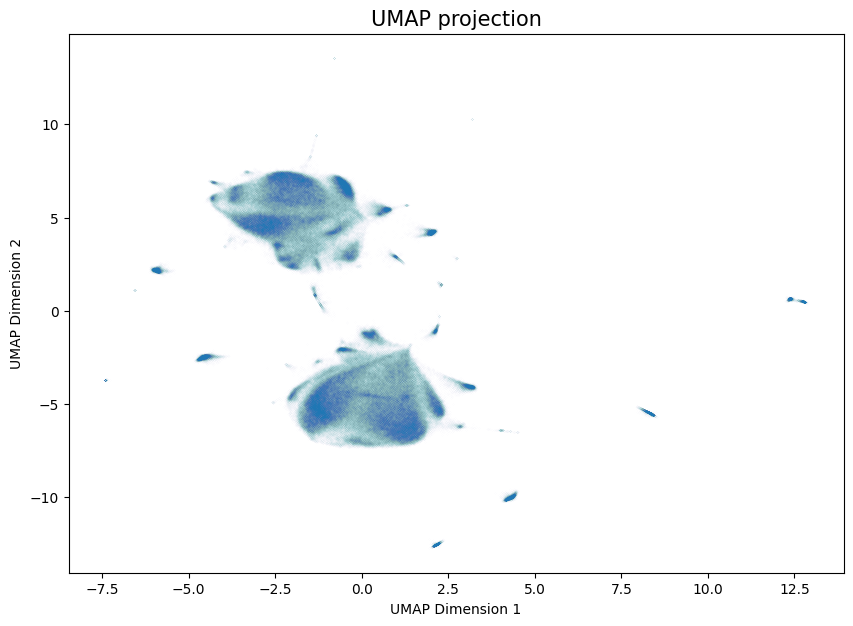

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(df_embed[0], df_embed[1], s=0.001, alpha=0.2)
plt.title('UMAP projection', fontsize=15)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


## Exploration of the UMAPPED data

In [7]:
df_result = df_embed.merge(df[['eid','21022','31','diseases_count','d_411.4']+[x for x in df.columns if x.startswith('c_')]], on='eid', how='left')

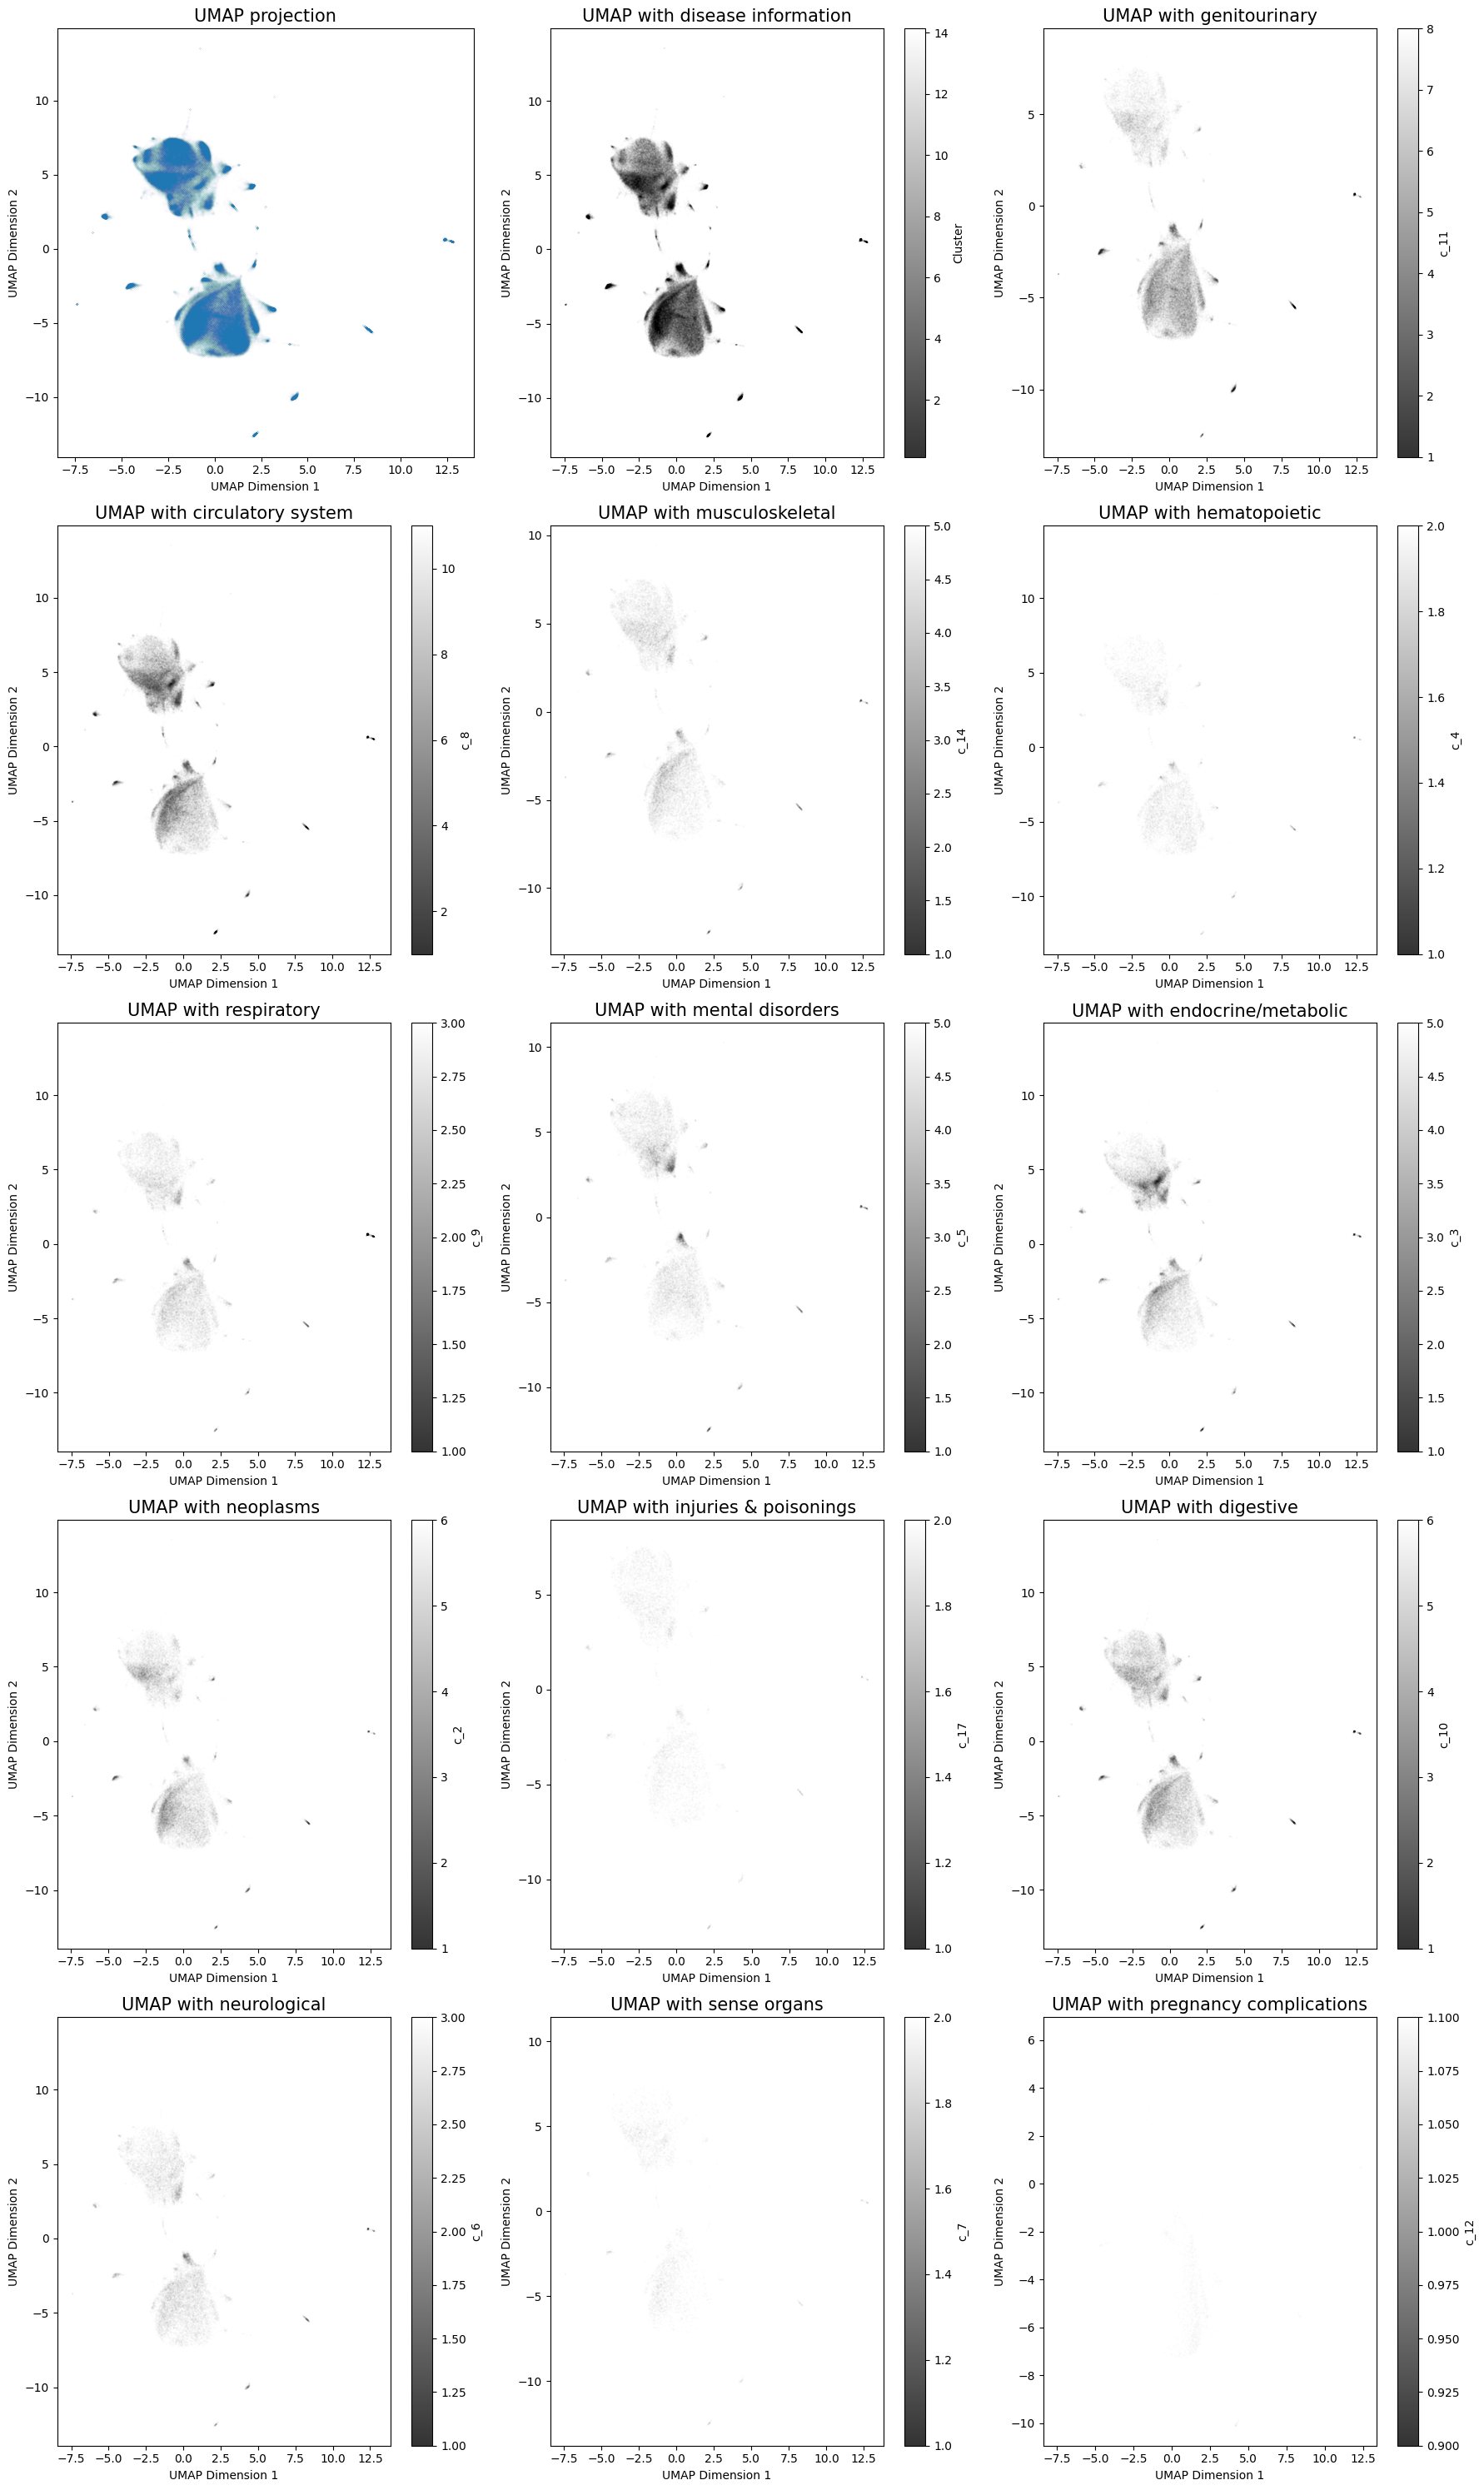

In [8]:
# Filter columns that start with "c_"
c_columns = [col for col in df_result.columns if str(col).startswith('c_')]
phe_cate_dict_rev = {v:k for k,v in params.phe_cate_dict.items()}
# Create a figure with the required number of subplots (1 for UMAP projection, 1 for clusters, and 1 for each "c_" column)
n_plots = 2 + len(c_columns)  # 2 initial plots + plots for each "c_" column
n_cols = 3  # You can change the number of columns per row
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a figure with the appropriate number of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axs = axs.flatten()  # Flatten the axs array for easy indexing

# Step 1: Plot the UMAP projection in the first subplot
axs[0].scatter(df_embed[0], df_embed[1], s=0.001, alpha=0.2)
axs[0].set_title('UMAP projection', fontsize=15)
axs[0].set_xlabel('UMAP Dimension 1')
axs[0].set_ylabel('UMAP Dimension 2')

# Step 2: Visualize clusters in the second subplot
df_subset = df_result.loc[df_result['diseases_count'] > 0, ]
scatter = axs[1].scatter(df_subset[0], df_subset[1], c=df_subset['diseases_count'], cmap='gist_gray', s=0.0001, alpha=0.8)
cbar = plt.colorbar(scatter, ax=axs[1], label='Cluster')
axs[1].set_title('UMAP with disease information', fontsize=15)
axs[1].set_xlabel('UMAP Dimension 1')
axs[1].set_ylabel('UMAP Dimension 2')

# Step 3: Loop through the "c_" columns and create a scatter plot for each, filtering values > 0
for i, col in enumerate(c_columns):
    # Filter rows where the value in the current "c_" column is greater than 0
    df_filtered = df_subset[df_subset[col] > 0]

    # Plot the filtered data
    scatter = axs[i + 2].scatter(df_filtered[0], df_filtered[1], c=df_filtered[col], cmap='gist_gray', s=0.0001, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=axs[i + 2], label=col)
    axs[i + 2].set_title(f'UMAP with {phe_cate_dict_rev[int(col.replace("c_",""))]}', fontsize=15)
    axs[i + 2].set_xlabel('UMAP Dimension 1')
    axs[i + 2].set_ylabel('UMAP Dimension 2')

# Hide any unused subplots if the number of plots is less than the grid size
for ax in axs[n_plots:]:
    ax.set_visible(False)

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the combined plot
# plt.show()
plt.savefig(Path.cwd().parents[1]/f'plot/umap_{n_components}_{n_neighbors}_{min_dist}.png')

# HDBSCAN

## with disease_count

In [9]:
import hdbscan
min_cluster_size=40
min_samples=1000

In [10]:

# Fit HDBSCAN on the 2D UMAP embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
labels = clusterer.fit_predict(df_result[[0, 1,'diseases_count']])


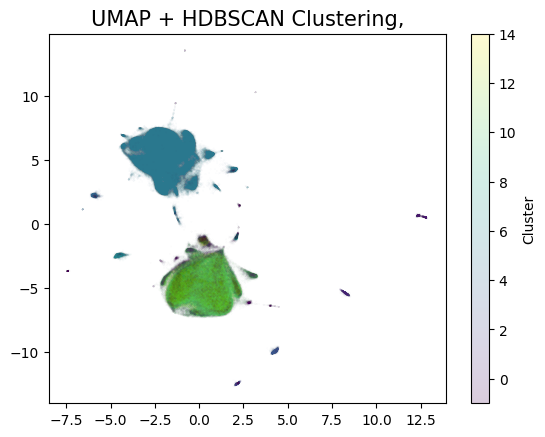

In [11]:
plt.scatter(df_result[0], df_result[1], c=labels, s=0.001, alpha=0.2)
plt.colorbar(label='Cluster')
plt.title(f'UMAP + HDBSCAN Clustering,', fontsize=15)
plt.show()

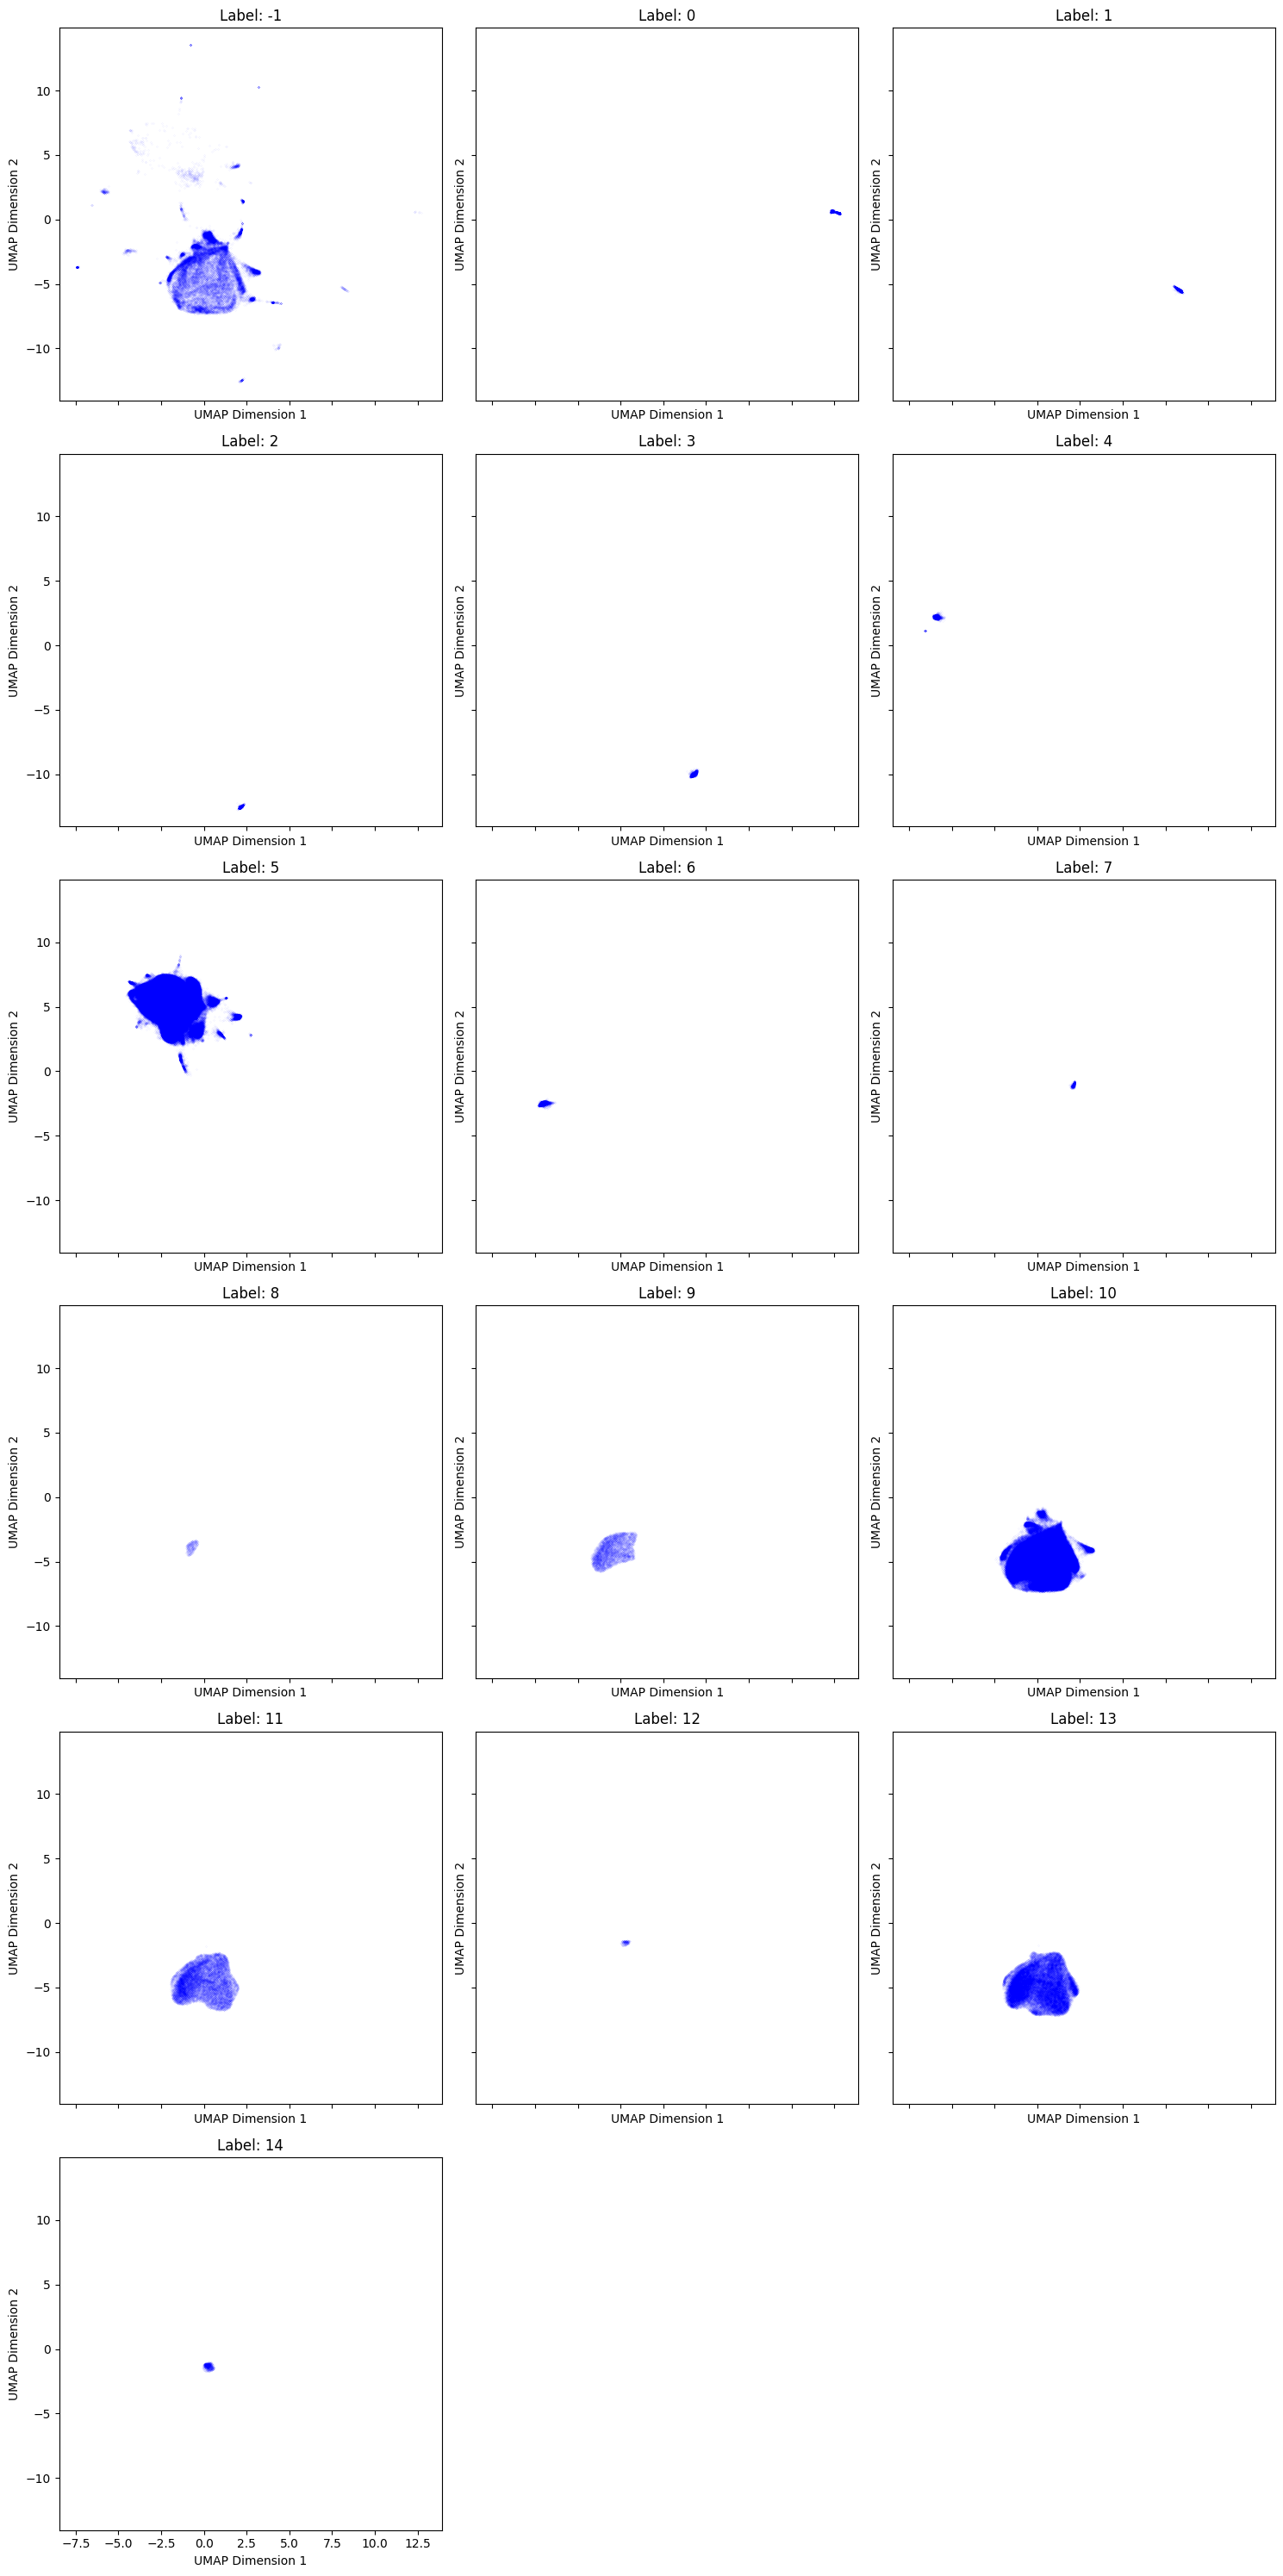

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique labels
unique_labels = np.unique(labels)

# Define the number of rows and columns for subplots based on the number of unique labels
n_cols = 3  # Number of columns
n_rows = (len(unique_labels) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a figure with multiple subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

# Loop through each unique label and create a scatter plot for each
for i, label in enumerate(unique_labels):
    ax = axs[i]

    # Filter data for the current label
    label_mask = (labels == label)
    # Plot the points not belonging to the current label in grey
    # ax.scatter(df_result[0][~label_mask], df_result[1][~label_mask], c='grey', s=0.001, alpha=0.2)

    # Plot the points with the current label in blue
    ax.scatter(df_result[0][label_mask], df_result[1][label_mask], c='blue', s=0.001, alpha=0.8, label=f'Label {label}')


    # Set titles and labels
    ax.set_title(f'Label: {label}', fontsize=12)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
# plt.show()
plt.savefig(Path.cwd().parents[1]/f'plot/hdbscan_{min_cluster_size}_{min_samples}.png')

In [13]:
df_labels = pd.DataFrame(columns =['label'], data=labels)
df_labels[['eid','diseases_count']]=df[['eid','diseases_count']]


<Axes: >

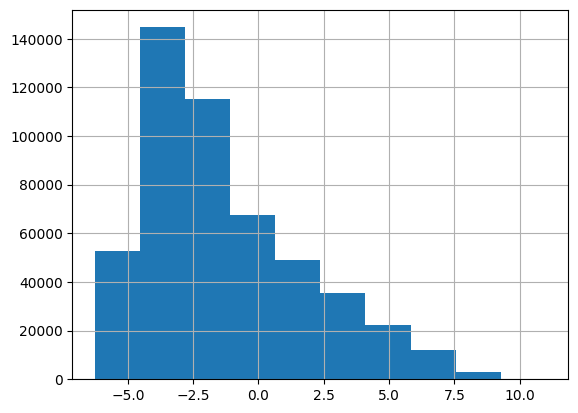

In [144]:
df_non_standard['22189'].hist()

In [140]:
# key vars
key_vars = {'21022': "age",'31': "gender", "10722":"education","738":"household income","22189":"Index of Multiple Deprivation","20117":"alcohol drinker","1200":"Sleeplessness / insomnia","1239":"Current tobacco smoking","20116":"smoking status","2178":"Overall health rating","2020":"Loneliness, isolation","23104":"Body mass index (BMI)","20277":"job code",'diseases_count':'Diseases count'}
for x in [x for x in df.columns if x.startswith('c_')]:
    key_vars[x] = phe_cate_dict_rev[int(x.replace('c_',''))]

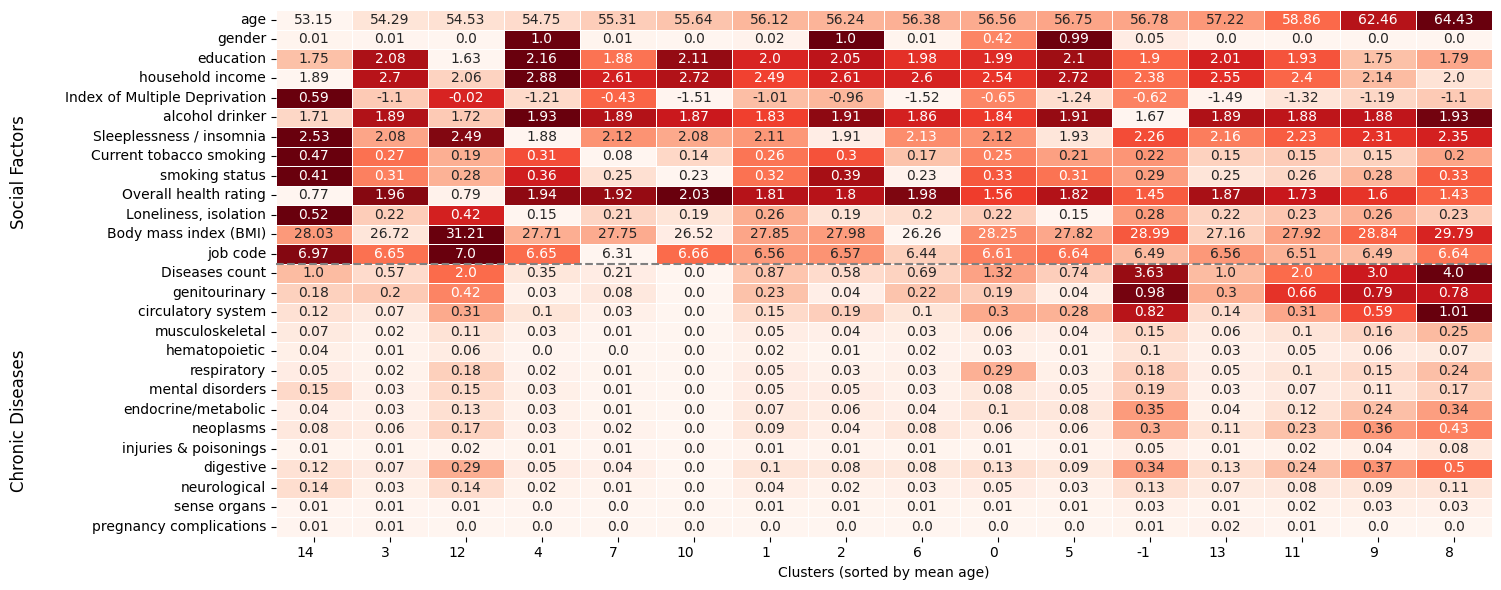

In [146]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ast

def plot_cluster_mean_heatmap_with_scaling(df, df_single_record, final_data_path, key_vars, non_replace, age_column, params, n_components, n_neighbors, min_dist, min_cluster_size, min_samples):
    # Load the non-standardized dataframe
    df_non_standard = pd.read_pickle(final_data_path / 'UKB_wave_0_final_non_standardised.pkl')
    df_non_standard[f'10722'].replace({3:1,2:1, list(df_non_standard['10722'].unique())[1]:1, 4:2,1:2,5:3},inplace=True)
    # Add the 'diseases_count' column from df_single_record to df_non_standard
    df_single_record['diseases_count'] = [len(ast.literal_eval(x)) if str(x) not in params.nan_str else 0 for x in df_single_record['diseases_within_window_phecode_selected_category_chronic_first_occ']]
    df_non_standard = df_non_standard.merge(df_single_record[['eid', 'diseases_count']], on='eid', how='left')

    # Add cluster labels to the non-standardized DataFrame
    df_non_standard['cluster'] = df['cluster']

    # Group by cluster and get the mean of key variables
    cluster_means = df.groupby('cluster')[list(key_vars.keys())].mean()

    # Exclude the columns in non_replace from scaling
    columns_to_scale = list(set(key_vars.keys()) - set(non_replace))

    # Scale the relevant columns in df between 0 and 1
    scaler = MinMaxScaler()
    cluster_means[columns_to_scale] = scaler.fit_transform(cluster_means[columns_to_scale])

    # Get the mean for non-standardized data, excluding columns in non_replace
    cluster_means_non_standard = df_non_standard.groupby('cluster')[columns_to_scale].mean()

    # Compute the mean age for each cluster and sort clusters by age
    mean_age_by_cluster = df.groupby('cluster')[age_column].mean()
    sorted_clusters = mean_age_by_cluster.sort_values().index

    # Reorder cluster_means and cluster_means_non_standard by sorted_clusters (based on mean age)
    cluster_means_sorted = cluster_means.loc[sorted_clusters]
    cluster_means_non_standard_sorted = cluster_means_non_standard.loc[sorted_clusters]

    # Prepare annotations: for columns in non_replace, use values from df; for others, use values from df_non_standard
    annotations = cluster_means_sorted.copy()  # Start with df annotations
    for column in key_vars.keys():
        if column not in non_replace:
            annotations[column] = round(cluster_means_non_standard_sorted[column], 2)
        else:
            annotations[column] = round(annotations[column], 2)
    annotations = annotations.T

    # Create the heatmap (rotated axes) based on df values (colors)
    plt.figure(figsize=(15, 6))
    ax = sns.heatmap(cluster_means_sorted.T, annot=annotations.values, fmt='', cmap='Reds', linewidths=0.5, cbar=False)

    # Rotate axes: clusters on the x-axis, key variables on the y-axis
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.set_yticklabels(list(key_vars.values()), rotation=0)

    diseases_count_index = list(key_vars.keys()).index('diseases_count')

    # Add the text annotations and the horizontal lines based on the diseases_count_index
    ax.text(-3.5, diseases_count_index - 2, 'Social Factors', rotation=90, fontsize=12)
    ax.hlines(diseases_count_index, 0, len(sorted_clusters)+3, colors='grey', linestyles='dashed')
    ax.text(-3.5, len(key_vars) - 2.5, 'Chronic Diseases', rotation=90, fontsize=12)


    plt.xlabel('Clusters (sorted by mean age)')


    # Show the plot
    plt.tight_layout()
    save_path = Path.cwd().parents[1] / f'plot/clustering/cluster_heatmap_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}.pdf'
    plt.savefig(save_path)
    plt.show()

non_replace= [x for x in df.columns if x.startswith('c_')]
plot_cluster_mean_heatmap_with_scaling(df, df_single_record, final_data_path, key_vars, non_replace, '21022', params, n_components, n_neighbors, min_dist, min_cluster_size, min_samples)
